**处理流程：** 使用增强后数据进行特征筛选
1. 缺失值填充 — 用 KNN（基于相似样本补齐）
2. 缩尾+Yeo-Johnson
3. 特征筛选 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# 公共常量定义
TARGET_COL = 'lipid(%)'

## 加载数据处理缺失值

In [2]:
df = pd.read_excel('../data/raw/row_data_augment.xlsx')
print(f'原始数据形状: {df.shape}')
print(f'缺失值统计:')
print(df.isnull().sum()[df.isnull().sum() > 0])

原始数据形状: (50, 19)
缺失值统计:
Series([], dtype: int64)


In [3]:
# 查看缺失值的具体情况
missing_cols = ['phosphate']

print('样本缺失：')
for col in missing_cols:
    missing_idx = df[df[col].isnull()].index.tolist()
    print(f'  {col}: {len(missing_idx)} 个缺失，第 {missing_idx} 行')

样本缺失：
  phosphate: 0 个缺失，第 [] 行


In [4]:
# 用 KNN 填充缺失值（只对数值列，避免用目标列参与填充）

print('KNN 填充缺失值：')
df_filled = df.copy()

# 仅对数值列做 KNN 填充，目标列不参与以避免泄露
numeric_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
imputer_cols = [c for c in numeric_cols if c != TARGET_COL]

missing_before = df_filled[imputer_cols].isna().sum()
imputer = KNNImputer(n_neighbors=5, weights='distance')

df_filled[imputer_cols] = imputer.fit_transform(df_filled[imputer_cols])

for col in missing_cols:
    before = missing_before.get(col, 0)
    after = df_filled[col].isna().sum()
    print(f'  {col}: 原有 {before} 个缺失，填充后剩余 {after} 个')


KNN 填充缺失值：
  phosphate: 原有 0 个缺失，填充后剩余 0 个


KNN 填充后数据形状: (50, 19)
数值列: 19 | 目标列: lipid(%)
正态性检验结果 (p<0.05 视为拒绝正态):
                           column   n        mean         std     shapiro_p   dagostino_p  shapiro_normal  \
0                              TP  50    0.436216    0.996602  1.269870e-12  9.317871e-20          reject   
1                       phosphate  50    0.168743    0.273138  1.066569e-09  6.221405e-09          reject   
2    Algal density（×10^5cells/ml)  50   20.984299   23.696922  2.100036e-09  9.560844e-06          reject   
3   Total photosynthetic pigments  50    0.700876    0.728159  1.114640e-07  5.734502e-05          reject   
4                ammonia nitrogen  50    0.375673    0.454133  2.557339e-07  7.506141e-06          reject   
5                             BOD  50    5.191273    5.094188  2.160598e-06  1.387869e-02          reject   
6                        lipid(%)  50    7.562991    5.786305  2.890716e-06  4.839038e-56          reject   
7                       Turbidity  50   11.972064   10.19

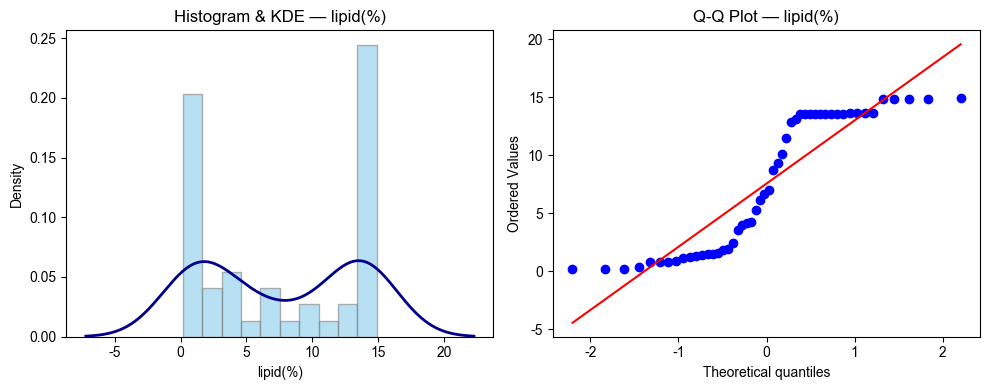

In [5]:
# KNN 填充后数据的正态性检验
from typing import Iterable

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

def infer_target_col(df, keywords: Iterable[str] = ('lipid', '脂质')) -> str:
    for col in df.columns:
        lower = str(col).lower()
        if any(key.lower() in lower for key in keywords):
            return col
    raise ValueError(f'No target column found containing any of {keywords}. Columns: {list(df.columns)}')

analysis_df = df_filled
y_col = infer_target_col(analysis_df)
num_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()

print(f'KNN 填充后数据形状: {analysis_df.shape}')
print(f'数值列: {len(num_cols)} | 目标列: {y_col}')

results = []
for col in num_cols:
    data = analysis_df[col].dropna().astype(float)
    n = len(data)
    if n < 8:  # normaltest 需要 n>=8
        continue
    shapiro_stat, shapiro_p = stats.shapiro(data)
    k2_stat, k2_p = stats.normaltest(data)
    results.append({
        'column': col,
        'n': n,
        'mean': data.mean(),
        'std': data.std(ddof=1),
        'shapiro_p': shapiro_p,
        'dagostino_p': k2_p,
        'shapiro_normal': 'fail to reject' if shapiro_p >= 0.05 else 'reject',
        'dagostino_normal': 'fail to reject' if k2_p >= 0.05 else 'reject',
    })

results_df = pd.DataFrame(results).sort_values('shapiro_p')
print('正态性检验结果 (p<0.05 视为拒绝正态):')
print(results_df.reset_index(drop=True))

# 直方图 + KDE 与 Q-Q 图，默认查看目标列，可根据需要改成其他列
column_to_plot = y_col
if column_to_plot not in num_cols:
    raise ValueError(f'Column {column_to_plot} not numeric. Choose one of: {num_cols}')

series = analysis_df[column_to_plot].dropna().astype(float)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(series, bins=10, density=True, alpha=0.6, color='skyblue', edgecolor='gray')
series.plot.kde(ax=axes[0], color='darkblue', lw=2)
axes[0].set_title(f'Histogram & KDE — {column_to_plot}')
axes[0].set_xlabel(column_to_plot)
axes[0].set_ylabel('Density')
stats.probplot(series, dist='norm', plot=axes[1])
axes[1].set_title(f'Q-Q Plot — {column_to_plot}')
plt.tight_layout()
plt.show()


In [6]:
output_path = '../data/processed/data_augment_cleaned.xlsx'
df_filled.to_excel(output_path, index=False)
print(f'数据保存路径: {output_path}')
print(f'数据状态: {df_filled.shape}')

数据保存路径: ../data/processed/data_augment_cleaned.xlsx
数据状态: (50, 19)


IQR 规则离群点数量（标准化前）：
                           column   n  outliers      lower        upper         min         max
0    Algal density（×10^5cells/ml)  50         8 -12.241321    39.418129    2.066670   84.188890
1                       phosphate  50         8  -0.244245     0.439741    0.001955    1.315000
2                             COD  50         7  -4.175798    58.281649    7.383197   70.400000
3   Total photosynthetic pigments  50         6  -0.746933     1.731555    0.035404    2.514000
4                              TP  50         4  -0.624023     1.115372    0.010000    6.503036
5                ammonia nitrogen  50         3  -0.765308     1.462180    0.000000    1.960000
6                             TOC  50         3   1.154195     8.779008    1.690000   11.310000
7                       Turbidity  50         1 -18.478352    42.087011    2.600000   46.650000
8            Specific growth rate  50         1  -0.103962     0.484380    0.025567    0.501775
9                    

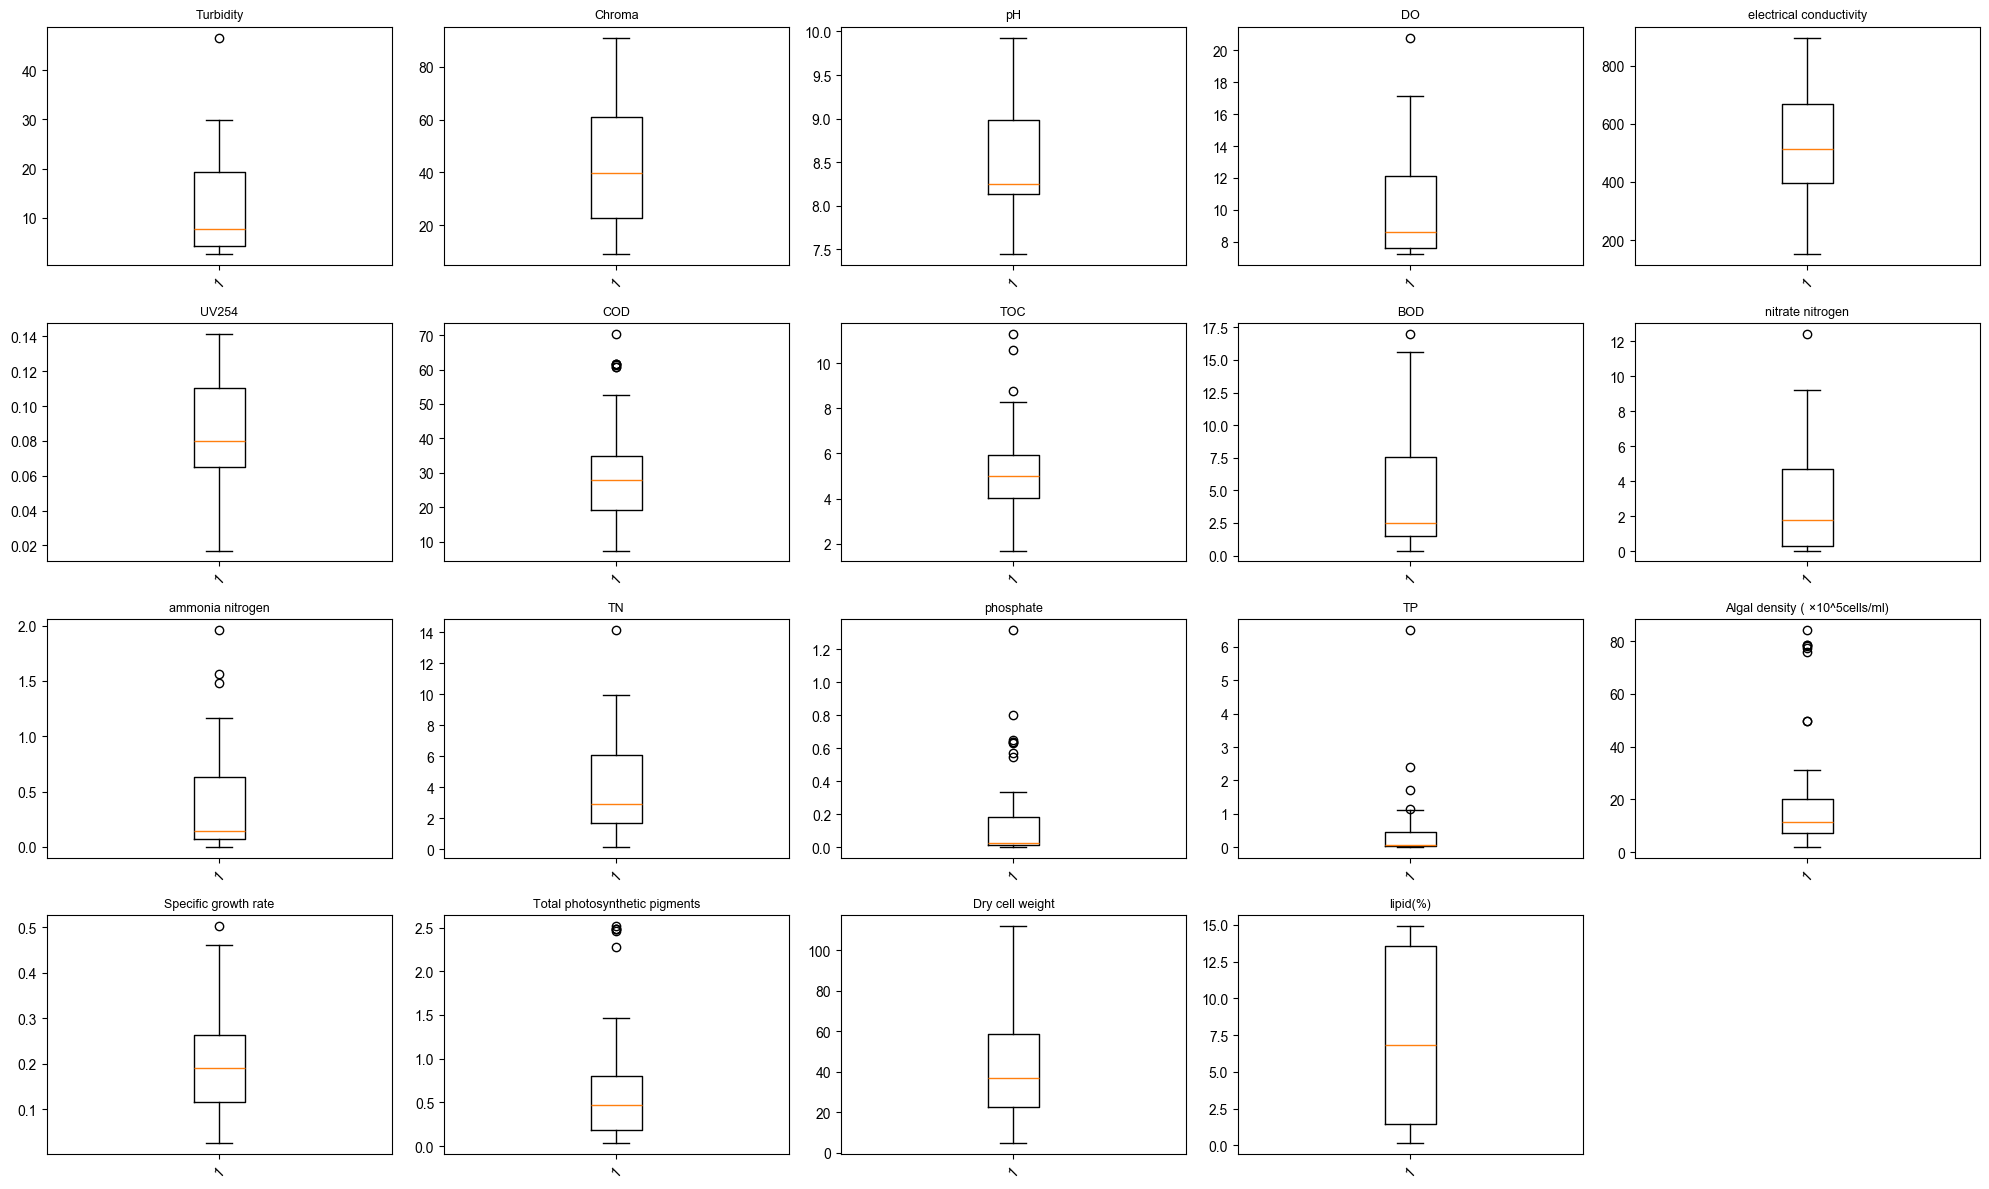

In [7]:
# KNN 填充后：箱线图查看离群值概况（标准化前）
num_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()

# IQR 规则统计离群点数量
outlier_summary = []
for col in num_cols:
    s = df_filled[col].dropna()
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (s < lower) | (s > upper)
    outlier_summary.append({
        'column': col,
        'n': s.shape[0],
        'outliers': int(mask.sum()),
        'lower': lower,
        'upper': upper,
        'min': s.min(),
        'max': s.max(),
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('outliers', ascending=False)
print('IQR 规则离群点数量（标准化前）：')
print(outlier_df.reset_index(drop=True))

# 箱线图展示
n_cols = 5
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()
for idx, col in enumerate(num_cols):
    axes[idx].boxplot(df_filled[col].dropna(), vert=True)
    axes[idx].set_title(col, fontsize=9)
    axes[idx].tick_params(axis='x', labelrotation=45)

# 关闭多余子图
for ax in axes[len(num_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
# 对离群明显的特征先做温和缩尾 (winsorize)，再用 Yeo-Johnson 标准化
from sklearn.preprocessing import PowerTransformer
from collections import OrderedDict

# 使用公共常量 TARGET_COL
y = df_filled[TARGET_COL].copy()

feature_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(TARGET_COL)
X = df_filled[feature_cols].copy()

# 处理可能存在的 inf 值
X = X.replace([np.inf, -np.inf], np.nan)

# 如果还有 NaN，用列中位数补全
for col in X.columns:
    if X[col].isna().any():
        X[col].fillna(X[col].median(), inplace=True)

# 基于 IQR 检测离群，离群列做 1%/99% 分位缩尾
winsor_bounds = OrderedDict()
for col in feature_cols:
    s = X[col]
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    if ((s < lower) | (s > upper)).any():
        lo, hi = s.quantile([0.01, 0.99])
        winsor_bounds[col] = (lo, hi)
        X[col] = s.clip(lower=lo, upper=hi)

print(f'缩尾处理列数: {len(winsor_bounds)}')
if winsor_bounds:
    for k, (lo, hi) in winsor_bounds.items():
        print(f'  {k}: 1%={lo:.4f}, 99%={hi:.4f}')

# Yeo-Johnson 变换 + 标准化
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = pt.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df_filled.index)

# 安全检查
if X_scaled_df.isna().any().any():
    X_scaled_df = X_scaled_df.fillna(0)
    print('注意: 变换后发现 NaN，已填充为 0')

print(f'Yeo-Johnson 标准化完成，共 {len(feature_cols)} 个特征')
for col in feature_cols[:3]:
    m = X_scaled_df[col].mean()
    s = X_scaled_df[col].std(ddof=0)
    print(f'  {col}: 均值={m:.4f}, 标准差={s:.4f}')


缩尾处理列数: 13
  Turbidity: 1%=2.6784, 99%=38.3935
  DO: 1%=7.2247, 99%=19.0019
  COD: 1%=7.4636, 99%=66.1370
  TOC: 1%=1.7586, 99%=10.9670
  BOD: 1%=0.4406, 99%=16.3085
  nitrate nitrogen: 1%=0.0329, 99%=10.8484
  ammonia nitrogen: 1%=0.0000, 99%=1.7640
  TN: 1%=0.4265, 99%=12.1062
  phosphate: 1%=0.0025, 99%=1.0642
  TP: 1%=0.0100, 99%=4.4891
  Algal density（×10^5cells/ml): 1%=3.1909, 99%=81.4189
  Specific growth rate: 1%=0.0480, 99%=0.4811
  Total photosynthetic pigments: 1%=0.0425, 99%=2.5000
Yeo-Johnson 标准化完成，共 18 个特征
  Turbidity: 均值=0.0000, 标准差=1.0000
  Chroma: 均值=-0.0000, 标准差=1.0000
  pH: 均值=-0.0000, 标准差=1.0000


In [9]:
# 标准化结果打包与保存
df_standardized = X_scaled_df.copy()
df_standardized[TARGET_COL] = y

output_path = '../data/processed/data_augment_standardized.xlsx'
df_standardized.to_excel(output_path, index=False)
print(f'标准化数据保存路径: {output_path}')
print(f'数据状态: {df_standardized.shape}')


标准化数据保存路径: ../data/processed/data_augment_standardized.xlsx
数据状态: (50, 19)


## 特征筛选

In [10]:
# 优化：使用公共常量 TARGET_COL，避免重复定义
df = df_standardized.copy()
y = df[TARGET_COL].values

feature_cols = df.columns.tolist()
feature_cols.remove(TARGET_COL)

X = df[feature_cols].values

print(f'特征数量: {len(feature_cols)}')
print(f'样本数量: {len(y)}')

特征数量: 18
样本数量: 50


In [11]:
# Pearson 相关系数
# 简单直观，看特征和目标的线性相关程度

corr_scores = {}
for i, col in enumerate(feature_cols):
    if np.isclose(np.std(X[:, i]), 0):
        corr_scores[col] = 0.0
        continue
    corr = np.corrcoef(X[:, i], y)[0, 1]
    corr_scores[col] = 0.0 if np.isnan(corr) else abs(corr)

print('相关系数前 14 ：')
for feat, score in sorted(corr_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

相关系数前 14 ：
  nitrate nitrogen: 0.298
  DO: 0.271
  pH: 0.247
  BOD: 0.193
  Dry cell weight: 0.191
  Chroma: 0.143
  UV254: 0.137
  TOC: 0.137
  COD: 0.107
  TN: 0.105
  electrical conductivity: 0.102
  phosphate: 0.073
  ammonia nitrogen: 0.064
  Total photosynthetic pigments: 0.046


In [12]:
# 随机森林
# 捕捉非线性关系，根据特征在树分裂时的贡献打分
rf = RandomForestRegressor(n_estimators=1000, max_depth=3,min_samples_leaf=3,min_samples_split=6,max_features="sqrt", random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_scores = dict(zip(feature_cols, rf.feature_importances_))

print('随机森林前 14 ：')
for feat, score in sorted(rf_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.4f}')

随机森林前 14 ：
  DO: 0.1168
  nitrate nitrogen: 0.1135
  TOC: 0.1072
  Turbidity: 0.0716
  TN: 0.0690
  BOD: 0.0681
  Total photosynthetic pigments: 0.0639
  pH: 0.0625
  COD: 0.0440
  Algal density（×10^5cells/ml): 0.0417
  Dry cell weight: 0.0405
  UV254: 0.0376
  electrical conductivity: 0.0315
  TP: 0.0308


In [13]:
# PLS 回归 (VIP 得分)
# VIP > 1 认为是重要特征

n_samples, n_features = X.shape
n_components = min(3, n_samples - 1, n_features)

pls = PLSRegression(n_components=n_components,scale=False)
pls.fit(X, y)

def calculate_vip(pls):
    t = pls.x_scores_          # (n, h)
    w = pls.x_weights_         # (p, h)
    q = pls.y_loadings_        # (m, h)  m=targets

    p, h = w.shape

    # 每个成分解释的 y 方差贡献（常见写法）
    s = np.sum(t**2, axis=0) * np.sum(q**2, axis=0)   # (h,)
    total_s = np.sum(s)
    if np.isclose(total_s, 0):
        return np.zeros(p)

    # 归一化每个成分的权重向量
    w_norm2 = (w / np.linalg.norm(w, axis=0))**2       # (p, h)

    vip = np.sqrt(p * (w_norm2 @ s) / total_s)         # (p,)
    return vip


pls_scores = dict(zip(feature_cols, calculate_vip(pls)))

print('PLS VIP 前 14 名：')
for feat, score in sorted(pls_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

PLS VIP 前 14 名：
  nitrate nitrogen: 1.533
  DO: 1.281
  Total photosynthetic pigments: 1.227
  pH: 1.215
  Dry cell weight: 1.148
  BOD: 1.138
  Chroma: 1.092
  TOC: 1.017
  TP: 0.999
  UV254: 0.892
  phosphate: 0.886
  electrical conductivity: 0.872
  Algal density（×10^5cells/ml): 0.817
  Specific growth rate: 0.802


In [14]:
# 递归特征消除 (RFE)
# 反复训练模型，每次剔除最不重要的特征，最后看哪些留到了最后

base_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0])
rfe = RFE(estimator=base_model, n_features_to_select=6, step=1)
rfe.fit(X, y)

max_rank = max(rfe.ranking_)
rfe_scores = {col: max_rank - rfe.ranking_[i] + 1 for i, col in enumerate(feature_cols)}

print('【RFE】最终保留的 6 个特征：')
for feat in np.array(feature_cols)[rfe.support_]:
    print(f'  {feat}')

【RFE】最终保留的 6 个特征：
  nitrate nitrogen
  TN
  Algal density（×10^5cells/ml)
  Specific growth rate
  Total photosynthetic pigments
  Dry cell weight


In [15]:
# Spearman 秩相关系数
# 衡量单调关系（不仅限于线性），对异常值更稳健

spearman_scores = {}
for i, col in enumerate(feature_cols):
    xi = X[:, i]
    if np.isclose(np.std(xi), 0):
        spearman_scores[col] = 0.0
        continue
    rho, _ = stats.spearmanr(xi, y, nan_policy='omit')
    spearman_scores[col] = 0.0 if np.isnan(rho) else abs(rho)


print('Spearman 秩相关前 14：')
for feat, score in sorted(spearman_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.3f}')

Spearman 秩相关前 14：
  pH: 0.270
  DO: 0.256
  UV254: 0.224
  nitrate nitrogen: 0.184
  Dry cell weight: 0.159
  Chroma: 0.150
  COD: 0.147
  BOD: 0.140
  TOC: 0.136
  Total photosynthetic pigments: 0.109
  electrical conductivity: 0.105
  Specific growth rate: 0.077
  Algal density（×10^5cells/ml): 0.067
  TN: 0.048


In [16]:
# 互信息 (Mutual Information)
# 捕捉任意类型的依赖关系（线性/非线性），基于信息论
const_mask = np.isclose(np.std(X, axis=0), 0)
mi_arr = mutual_info_regression(X, y, random_state=42, n_neighbors=5)
mi_arr[const_mask] = 0.0

mi_scores = dict(zip(feature_cols, mi_arr))

print('互信息 MI 前 14：')
for feat, score in sorted(mi_scores.items(), key=lambda x: -x[1])[:14]:
    print(f'  {feat}: {score:.4f}')

互信息 MI 前 14：
  nitrate nitrogen: 0.3399
  TN: 0.3198
  TOC: 0.3119
  Turbidity: 0.2395
  COD: 0.2261
  Total photosynthetic pigments: 0.1702
  BOD: 0.1392
  Chroma: 0.1150
  Algal density（×10^5cells/ml): 0.1018
  DO: 0.0782
  Specific growth rate: 0.0729
  electrical conductivity: 0.0677
  TP: 0.0453
  pH: 0.0250


In [17]:
# 综合得分只看 Spearman 与 PLS (两种方法平均)

def normalize(scores):
    vals = np.array(list(scores.values()))
    vals = np.nan_to_num(vals, nan=0.0)
    if vals.max() - vals.min() > 0:
        normed = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        normed = np.zeros_like(vals)
    return dict(zip(scores.keys(), normed))

scores_dict = {
    'Spearman': spearman_scores,
    'PLS': pls_scores
}

feature_cols = list(scores_dict['Spearman'].keys())

data = {'feature': feature_cols}
for name, scores in scores_dict.items():
    data[f'{name}_Raw'] = [scores[f] for f in feature_cols]
for name, scores in scores_dict.items():
    norm_scores = normalize(scores)
    data[name] = [norm_scores[f] for f in feature_cols]

summary_df = pd.DataFrame(data)
summary_df['Average'] = summary_df[list(scores_dict.keys())].mean(axis=1)
summary_df = summary_df.sort_values('Average', ascending=False)

print('【综合排名】前 10 名（Spearman + PLS）：')
print(summary_df[['feature', 'Average']].head(10).to_string(index=False))


【综合排名】前 10 名（Spearman + PLS）：
                      feature  Average
                           DO 0.865051
                           pH 0.862462
             nitrate nitrogen 0.841629
                        UV254 0.636998
              Dry cell weight 0.627733
                          BOD 0.589148
                       Chroma 0.586901
Total photosynthetic pigments 0.568725
                          TOC 0.528554
      electrical conductivity 0.407522


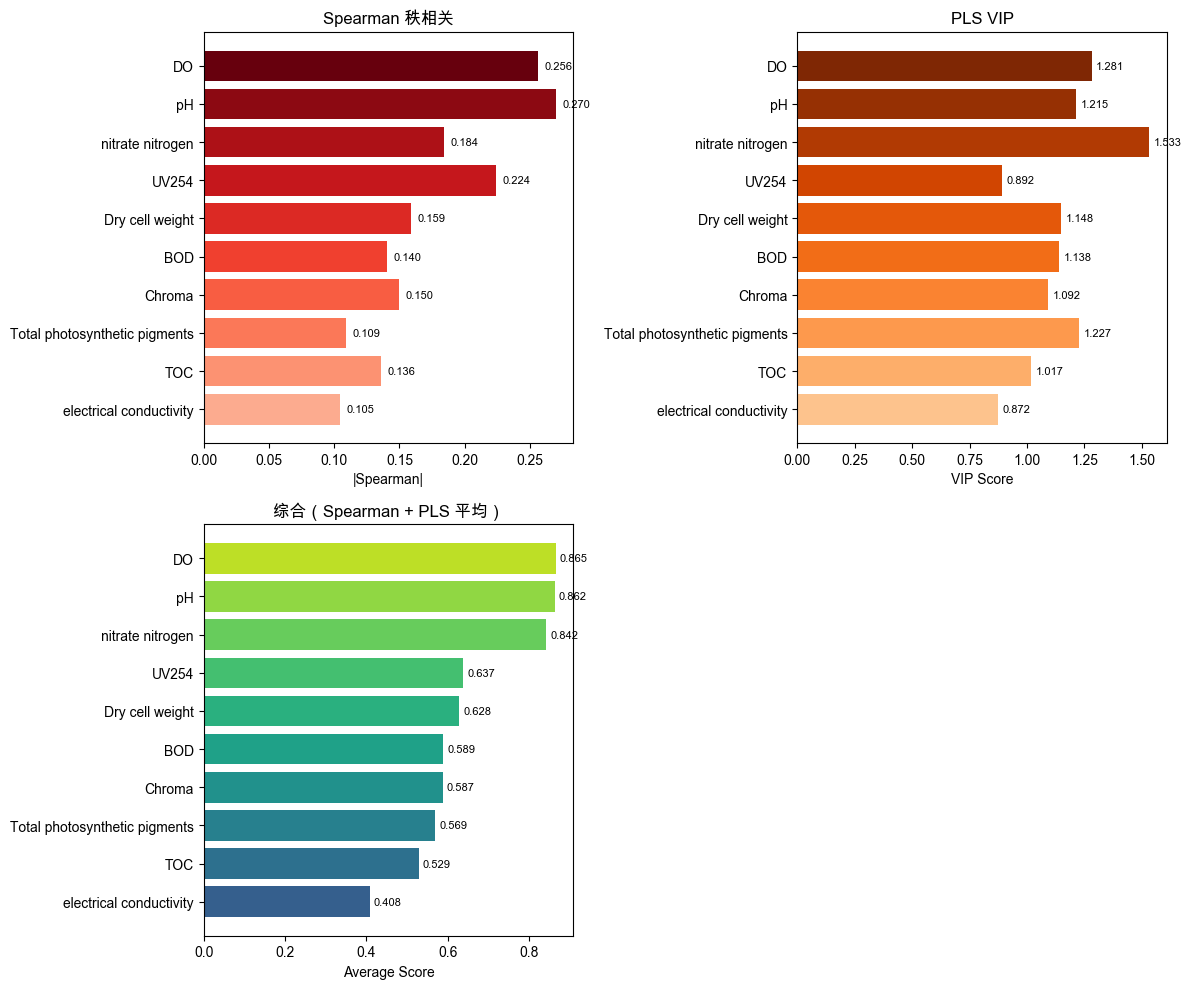

图表保存至: ../results/feature_selection_comparison_augment.png


In [18]:
top_n = 10
top_features = summary_df.head(top_n)['feature'].tolist()
plot_df = summary_df[summary_df['feature'].isin(top_features)].copy().set_index('feature')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Spearman
ax = axes[0]
vals = plot_df.loc[top_features, 'Spearman_Raw'].values
ax.barh(top_features, vals, color=plt.cm.Reds(np.linspace(0.3, 1, top_n))[::-1])
ax.set_xlabel('|Spearman|')
ax.set_title('Spearman 秩相关')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=8)

# PLS
ax = axes[1]
vals = plot_df.loc[top_features, 'PLS_Raw'].values
ax.barh(top_features, vals, color=plt.cm.Oranges(np.linspace(0.3, 1, top_n))[::-1])
ax.set_xlabel('VIP Score')
ax.set_title('PLS VIP')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=8)

# Average (Spearman + PLS)
ax = axes[2]
vals = plot_df.loc[top_features, 'Average'].values
ax.barh(top_features, vals, color=plt.cm.viridis(np.linspace(0.3, 0.9, top_n))[::-1])
ax.set_xlabel('Average Score')
ax.set_title('综合（Spearman + PLS 平均）')
ax.invert_yaxis()
for i, v in enumerate(vals):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

# hide unused subplot
axes[3].axis('off')

plt.tight_layout()
plt.savefig('../results/feature_selection/feature_selection_comparison_augment.png', dpi=300, bbox_inches='tight')
plt.show()

print('图表保存至: ../results/feature_selection/feature_selection_comparison_augment.png')


In [19]:
# 保存结果
summary_df.to_excel('../results/feature_selection/feature_selection_results_augment.xlsx', index=False)

print('结果已保存')
print('前 10 特征：')
for i, feat in enumerate(summary_df.head(10)['feature'].tolist(), 1):
    print(f'  {i}. {feat}')

结果已保存
前 10 特征：
  1. DO
  2. pH
  3. nitrate nitrogen
  4. UV254
  5. Dry cell weight
  6. BOD
  7. Chroma
  8. Total photosynthetic pigments
  9. TOC
  10. electrical conductivity


  transform      RMSE       MAE        R2
0       原始y  3.614063  2.560758  0.601927
1  log1p(y)  3.200437  2.279411  0.687831


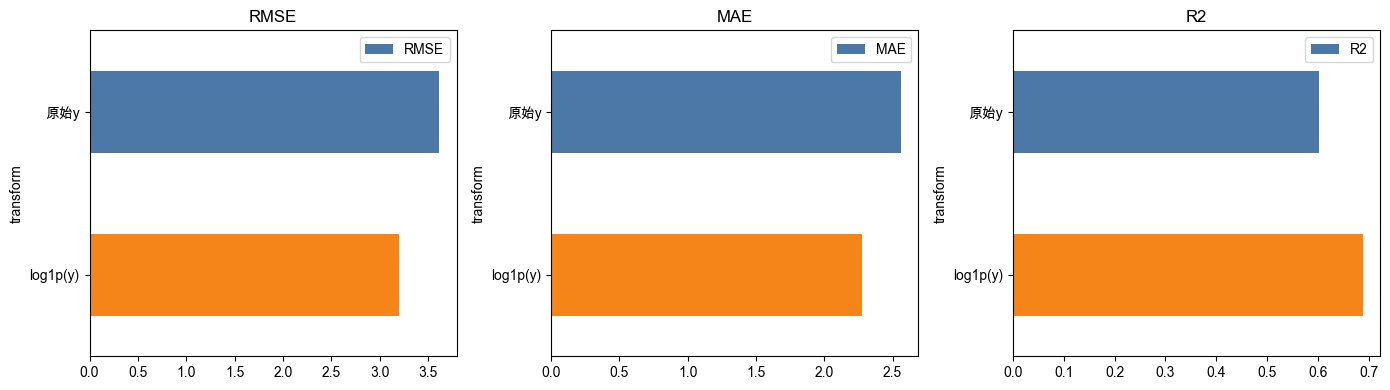

图已保存: ../results/xgb_full_repeated_augment.png


In [20]:
# 基线 A：全特征 XGBoost Repeated 5×5 CV（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

X = df_standardized.drop(columns=[TARGET_COL])
y = df_standardized[TARGET_COL]

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

results = []
for transform in [False, True]:
    preds, truths = [], []
    for train_idx, test_idx in rkf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_train_fit = np.log1p(y_train) if transform else y_train
        model = XGBRegressor(**model_params)
        model.fit(X_train, y_train_fit)
        y_pred = model.predict(X_test)
        if transform:
            y_pred = np.expm1(y_pred)
        preds.append(np.array(y_pred).ravel())
        truths.append(y_test.values)
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(truths)
    rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    tag = 'log1p(y)' if transform else '原始y'
    results.append({'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, metric, colors in zip(axes, ['RMSE','MAE','R2'], [['#4C78A8','#F58518']]*3):
    res_df.plot(kind='barh', x='transform', y=metric, ax=ax, color=colors)
    ax.set_title(metric)
    ax.invert_yaxis()
plt.tight_layout()
img_path = '../results/xgb/xgb_full_repeated_augment.png'
plt.savefig(img_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'图已保存: {img_path}')


  transform      RMSE       MAE        R2
0       原始y  3.384786  2.185924  0.650833
1  log1p(y)  3.151391  2.164240  0.697325


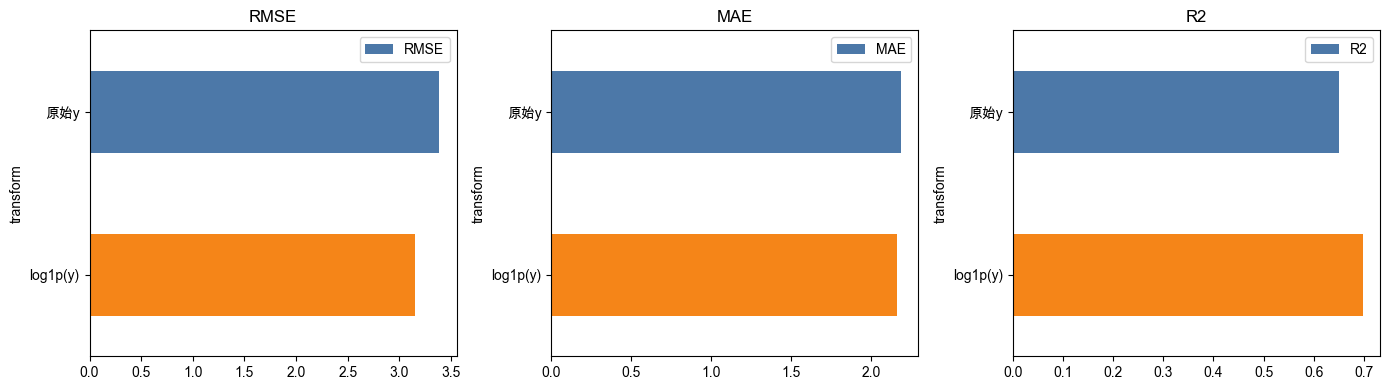

图已保存: ../results/xgb_subset_repeated_augment.png
特征列表: ['DO', 'pH', 'nitrate nitrogen', 'UV254', 'Dry cell weight', 'BOD']


In [21]:
# 基线 B：前6特征 XGBoost Repeated 5×5 CV（图表， RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

subset_features = summary_df.head(6)['feature'].tolist()
X = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

results = []
for transform in [False, True]:
    preds, truths = [], []
    for train_idx, test_idx in rkf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        y_train_fit = np.log1p(y_train) if transform else y_train
        model = XGBRegressor(**model_params)
        model.fit(X_train, y_train_fit)
        y_pred = model.predict(X_test)
        if transform:
            y_pred = np.expm1(y_pred)
        preds.append(np.array(y_pred).ravel())
        truths.append(y_test.values)
    y_pred_all = np.concatenate(preds)
    y_true_all = np.concatenate(truths)
    rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    tag = 'log1p(y)' if transform else '原始y'
    results.append({'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, metric, colors in zip(axes, ['RMSE','MAE','R2'], [['#4C78A8','#F58518']]*3):
    res_df.plot(kind='barh', x='transform', y=metric, ax=ax, color=colors)
    ax.set_title(metric)
    ax.invert_yaxis()
plt.tight_layout()
img_path = '../results/xgb/xgb_subset_repeated_augment.png'
plt.savefig(img_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'图已保存: {img_path}')
print(f'特征列表: {subset_features}')


    set transform      RMSE       MAE        R2
0   全特征       原始y  3.425579  2.393194  0.642366
1   全特征  log1p(y)  3.135763  2.221135  0.700320
2  前6特征       原始y  3.183943  2.081856  0.691040
3  前6特征  log1p(y)  3.155120  2.232480  0.696609


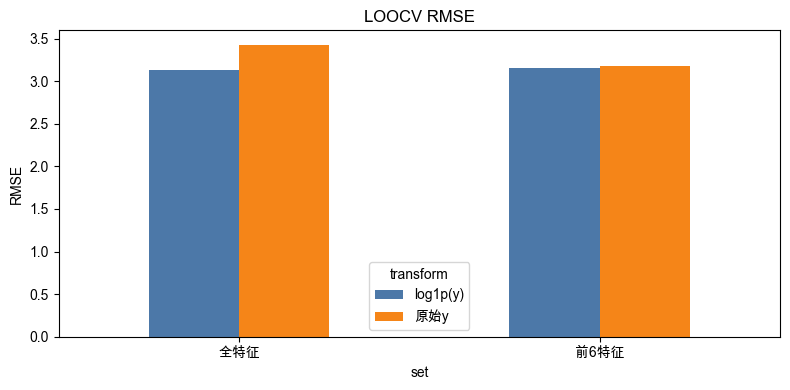

RMSE 图已保存: ../results/xgb_loocv_augment_rmse.png


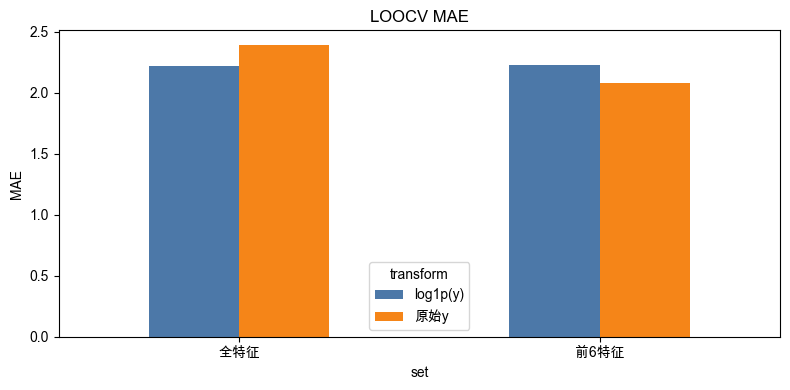

MAE 图已保存: ../results/xgb_loocv_augment_mae.png


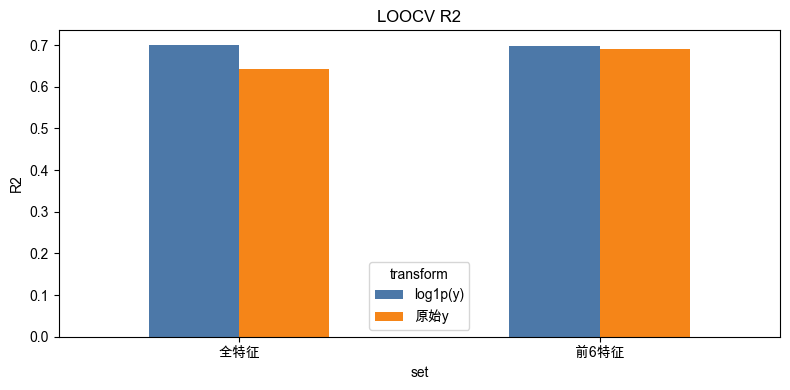

R2 图已保存: ../results/xgb_loocv_augment_r2.png
特征列表: ['DO', 'pH', 'nitrate nitrogen', 'UV254', 'Dry cell weight', 'BOD']


In [22]:
# LOOCV：全特征 vs 前6，XGBoost（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

X_full = df_standardized.drop(columns=[TARGET_COL])
subset_features = summary_df.head(6)['feature'].tolist()
X_sub = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

model_params = dict(
    n_estimators=300, learning_rate=0.05, max_depth=3,
    subsample=0.8, colsample_bytree=0.8, min_child_weight=1.0,
    reg_lambda=1.0, random_state=42, objective='reg:squarederror'
)

loo = LeaveOneOut()
results = []
for name, X_curr in [('全特征', X_full), ('前6特征', X_sub)]:
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in loo.split(X_curr):
            X_train, X_test = X_curr.iloc[train_idx], X_curr.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = XGBRegressor(**model_params)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else '原始y'
        results.append({'set': name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(8,4))
    pivot = res_df.pivot(index='set', columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'LOOCV {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=0)
    plt.tight_layout()
    img_path = f"../results/xgb/xgb_loocv_augment_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')
print(f'特征列表: {subset_features}')


          model transform      RMSE       MAE        R2
0         Ridge       原始y  5.332076  3.972967  0.133509
1         Ridge  log1p(y)  5.766192  4.232914 -0.013327
2         Lasso       原始y  5.111250  3.369282  0.203794
3         Lasso  log1p(y)  5.864166  3.964612 -0.048054
4    ElasticNet       原始y  5.050903  3.479189  0.222484
5    ElasticNet  log1p(y)  5.520544  3.818709  0.071173
6           PLS       原始y  6.191367  5.210129 -0.168273
7           PLS  log1p(y)  6.811649  5.559939 -0.414086
8  RandomForest       原始y  3.921504  2.992489  0.531320
9  RandomForest  log1p(y)  3.553340  2.850916  0.615191


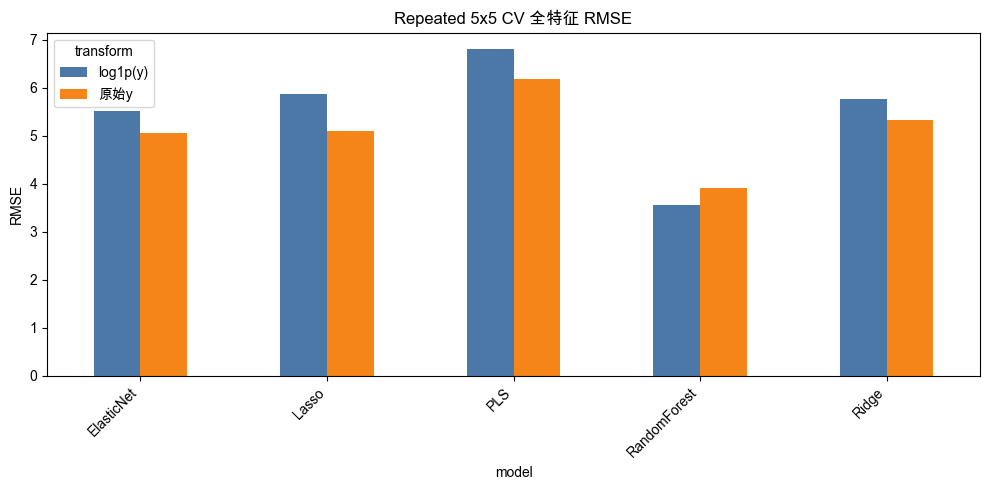

RMSE 图已保存: ../results/lin_pls_rf_full_augment_rmse.png


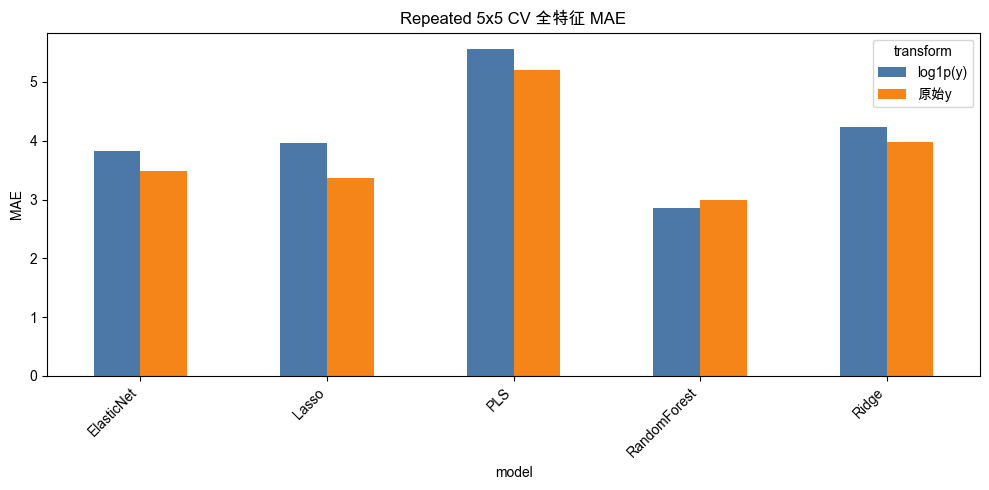

MAE 图已保存: ../results/lin_pls_rf_full_augment_mae.png


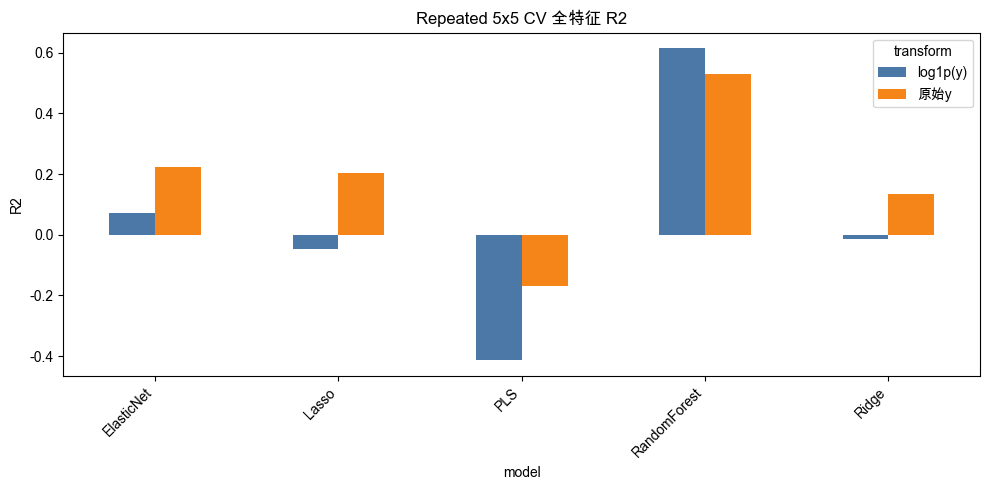

R2 图已保存: ../results/lin_pls_rf_full_augment_r2.png


In [23]:
# 基线 C：线性/PLS/RF 全特征 Repeated 5×5 CV（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

X = df_standardized.drop(columns=[TARGET_COL])
y = df_standardized[TARGET_COL]

models = {
    'Ridge': lambda n_features: Ridge(alpha=1.0, random_state=42),
    'Lasso': lambda n_features: Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': lambda n_features: ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y) - 1), scale=False),
    'RandomForest': lambda n_features: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
results = []
for model_name, make_model in models.items():
    n_features = X.shape[1]
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = make_model(n_features)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else '原始y'
        results.append({'model': model_name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(10,5))
    pivot = res_df.pivot(index='model', columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'Repeated 5x5 CV 全特征 {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    img_path = f"../results/lin_pls_rf/lin_pls_rf_full_augment_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')


          model transform      RMSE       MAE        R2
0         Ridge       原始y  6.072088  5.341150 -0.123692
1         Ridge  log1p(y)  6.435905  5.482842 -0.262382
2         Lasso       原始y  6.108618  5.348509 -0.137253
3         Lasso  log1p(y)  6.377755  5.463062 -0.239673
4    ElasticNet       原始y  6.105031  5.347886 -0.135918
5    ElasticNet  log1p(y)  6.427413  5.482926 -0.259052
6           PLS       原始y  6.137191  5.388210 -0.147917
7           PLS  log1p(y)  6.389804  5.408085 -0.244361
8  RandomForest       原始y  3.590228  2.522507  0.607160
9  RandomForest  log1p(y)  3.412136  2.554141  0.645167


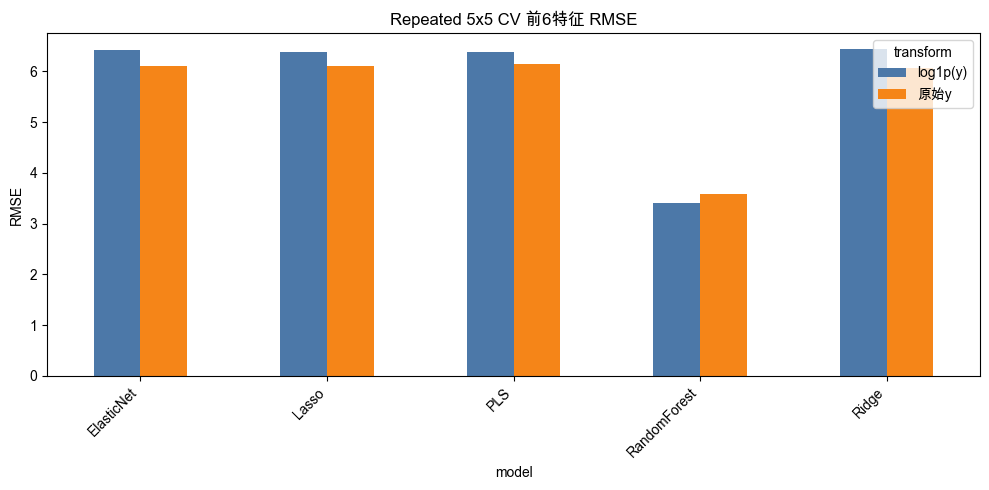

RMSE 图已保存: ../results/lin_pls_rf_sub_augment_rmse.png


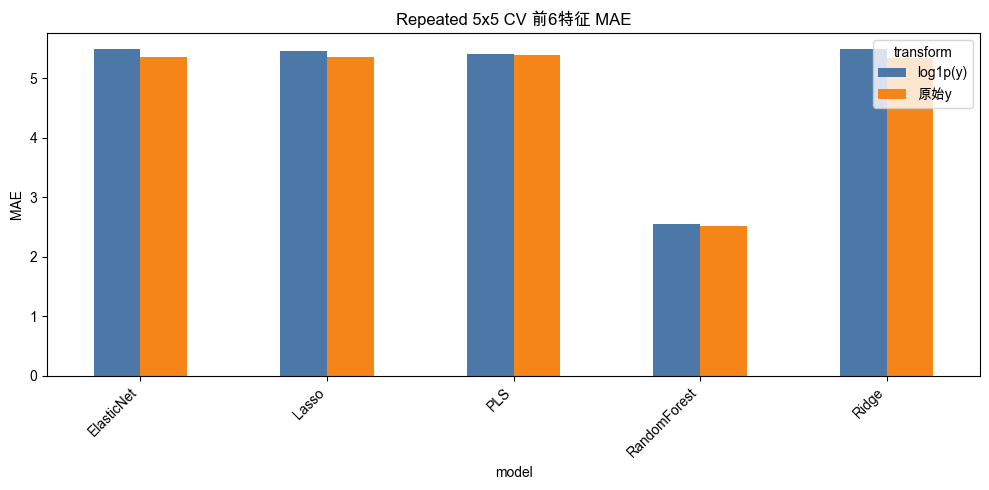

MAE 图已保存: ../results/lin_pls_rf_sub_augment_mae.png


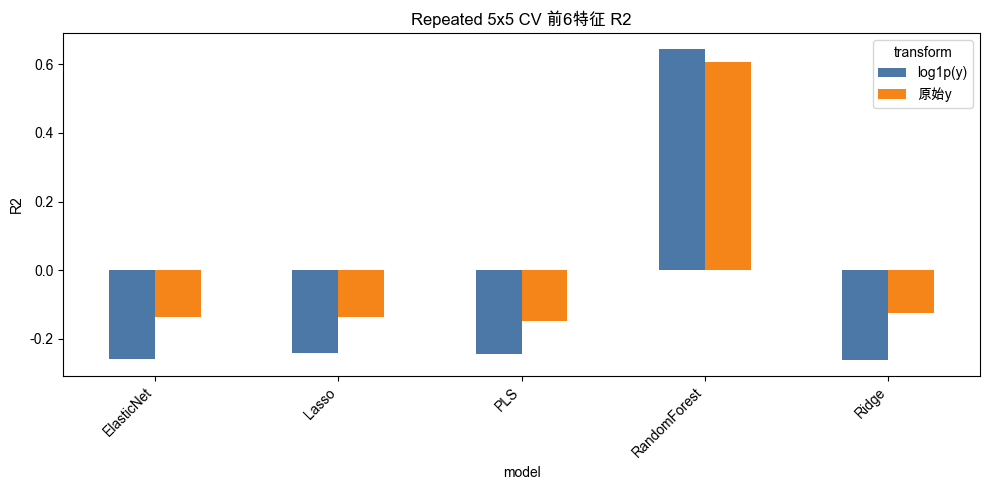

R2 图已保存: ../results/lin_pls_rf_sub_augment_r2.png
特征列表: ['DO', 'pH', 'nitrate nitrogen', 'UV254', 'Dry cell weight', 'BOD']


In [24]:
# 基线 D：线性/PLS/RF 前6特征 Repeated 5×5 CV（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

subset_features = summary_df.head(6)['feature'].tolist()
X = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

models = {
    'Ridge': lambda n_features: Ridge(alpha=1.0, random_state=42),
    'Lasso': lambda n_features: Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': lambda n_features: ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y) - 1), scale=False),
    'RandomForest': lambda n_features: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
results = []
for model_name, make_model in models.items():
    n_features = X.shape[1]
    for transform in [False, True]:
        preds, truths = [], []
        for train_idx, test_idx in rkf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            y_train_fit = np.log1p(y_train) if transform else y_train
            model = make_model(n_features)
            model.fit(X_train, y_train_fit)
            y_pred = model.predict(X_test)
            if transform:
                y_pred = np.expm1(y_pred)
            preds.append(np.array(y_pred).ravel())
            truths.append(y_test.values)
        y_pred_all = np.concatenate(preds)
        y_true_all = np.concatenate(truths)
        rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
        mae = mean_absolute_error(y_true_all, y_pred_all)
        r2 = r2_score(y_true_all, y_pred_all)
        tag = 'log1p(y)' if transform else '原始y'
        results.append({'model': model_name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(10,5))
    pivot = res_df.pivot(index='model', columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'Repeated 5x5 CV 前6特征 {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    img_path = f"../results/lin_pls_rf/lin_pls_rf_sub_augment_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')
print(f'特征列表: {subset_features}')


     set         model transform      RMSE       MAE        R2
0    全特征         Ridge       原始y  4.728555  3.488396  0.318559
1    全特征         Ridge  log1p(y)  4.637707  3.752765  0.344492
2    全特征         Lasso       原始y  4.383334  2.737662  0.414428
3    全特征         Lasso  log1p(y)  4.376264  3.399106  0.416315
4    全特征    ElasticNet       原始y  4.378164  2.944970  0.415808
5    全特征    ElasticNet  log1p(y)  4.312107  3.363080  0.433304
6    全特征           PLS       原始y  6.178898  5.326956 -0.163572
7    全特征           PLS  log1p(y)  6.368781  5.448422 -0.236186
8    全特征  RandomForest       原始y  3.737709  2.847550  0.574223
9    全特征  RandomForest  log1p(y)  3.434284  2.742674  0.640546
10  前6特征         Ridge       原始y  6.061055  5.406029 -0.119613
11  前6特征         Ridge  log1p(y)  6.558120  5.554393 -0.310781
12  前6特征         Lasso       原始y  6.072218  5.393677 -0.123740
13  前6特征         Lasso  log1p(y)  6.488798  5.545501 -0.283216
14  前6特征    ElasticNet       原始y  6.076720  5.402731 -0

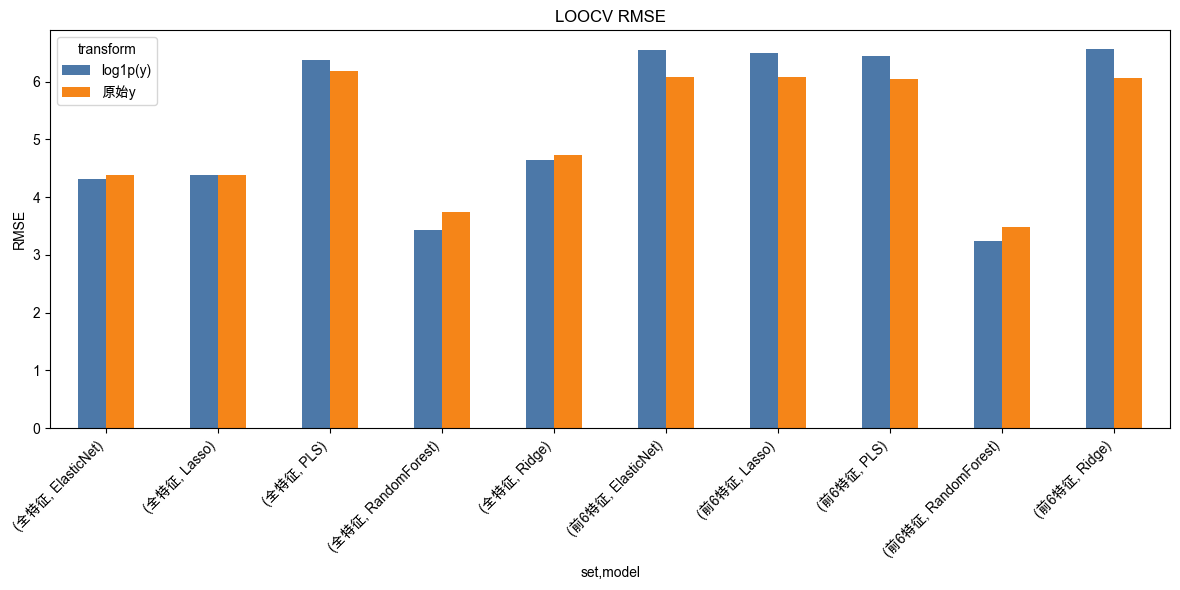

RMSE 图已保存: ../results/lin_pls_rf_loo_augment_rmse.png


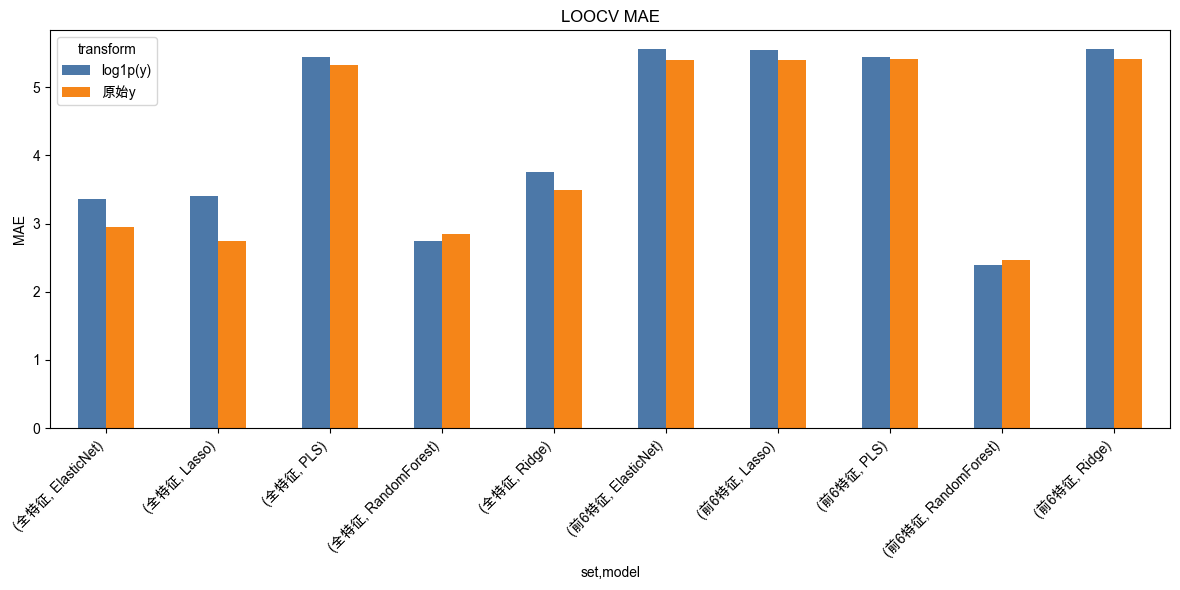

MAE 图已保存: ../results/lin_pls_rf_loo_augment_mae.png


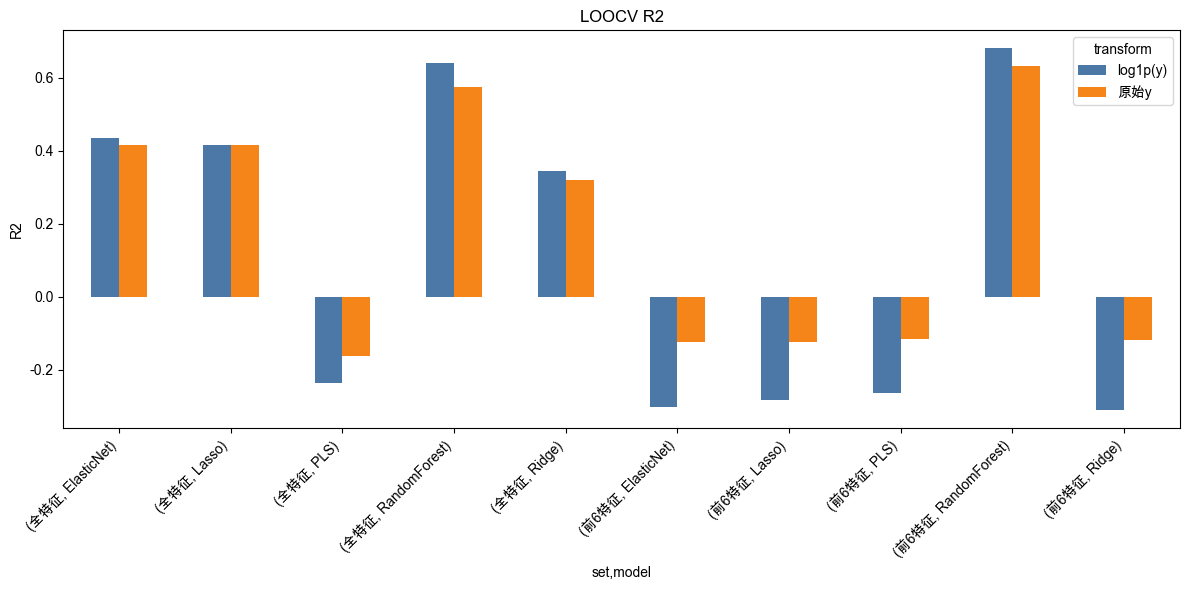

R2 图已保存: ../results/lin_pls_rf_loo_augment_r2.png
特征列表: ['DO', 'pH', 'nitrate nitrogen', 'UV254', 'Dry cell weight', 'BOD']


In [25]:
# 线性/PLS/RF LOOCV 对照（图表，含 RMSE/MAE/R2）
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

X_full = df_standardized.drop(columns=[TARGET_COL])
subset_features = summary_df.head(6)['feature'].tolist()
X_sub = df_standardized[subset_features]
y = df_standardized[TARGET_COL]

models = {
    'Ridge': lambda n_features: Ridge(alpha=1.0, random_state=42),
    'Lasso': lambda n_features: Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet': lambda n_features: ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
    'PLS': lambda n_features: PLSRegression(n_components=min(3, n_features, len(y) - 1), scale=False),
    'RandomForest': lambda n_features: RandomForestRegressor(n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
}

loo = LeaveOneOut()
results = []
for name, X_curr in [('全特征', X_full), ('前6特征', X_sub)]:
    for model_name, make_model in models.items():
        for transform in [False, True]:
            preds, truths = [], []
            for train_idx, test_idx in loo.split(X_curr):
                X_train, X_test = X_curr.iloc[train_idx], X_curr.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                y_train_fit = np.log1p(y_train) if transform else y_train
                model = make_model(X_curr.shape[1])
                model.fit(X_train, y_train_fit)
                y_pred = model.predict(X_test)
                if transform:
                    y_pred = np.expm1(y_pred)
                preds.append(np.array(y_pred).ravel())
                truths.append(y_test.values)
            y_pred_all = np.concatenate(preds)
            y_true_all = np.concatenate(truths)
            rmse = mean_squared_error(y_true_all, y_pred_all) ** 0.5
            mae = mean_absolute_error(y_true_all, y_pred_all)
            r2 = r2_score(y_true_all, y_pred_all)
            tag = 'log1p(y)' if transform else '原始y'
            results.append({'set': name, 'model': model_name, 'transform': tag, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results)
print(res_df)

for metric in ['RMSE','MAE','R2']:
    fig, ax = plt.subplots(figsize=(12,6))
    pivot = res_df.pivot(index=['set','model'], columns='transform', values=metric)
    pivot.plot(kind='bar', ax=ax, color=['#4C78A8','#F58518'])
    ax.set_title(f'LOOCV {metric}')
    ax.set_ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    img_path = f"../results/lin_pls_rf/lin_pls_rf_loo_augment_{metric.lower()}.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'{metric} 图已保存: {img_path}')
print(f'特征列表: {subset_features}')
